#(Easy) High performance text processing in Machine Learning*

#[Rosetta*](https://github.com/columbia-applied-data-science/rosetta) 

##Tools for data science with a focus on text processing.

* Focuses on "medium data", i.e. data too big to fit into memory but too small to necessitate the use of a cluster.
* Integrates with existing scientific Python stack as well as select outside tools.

## Tools and utilities 

### `cmd` 
* Unix-like command line utilities.  Filters (read from stdin/write to stdout) for files

### `parallel` 
* Wrappers for Python multiprocessing that add ease of use
* Memory-friendly multiprocessing

### `text`
* Stream text from disk to formats used in common ML processes
    * file, database, and generic streamers
* Write processed text to sparse formats
* Helpers for ML tools (e.g. Vowpal Wabbit, Gensim, etc...)
* Other general utilities

### `workflow`
* High-level wrappers that have helped with our workflow and provide additional examples of code use

### `modeling`
* General ML modeling utilities


#Lets begin

###For the purpose of this tutorial, we will be working with body of about 5 declassified government embassy cables.


In [2]:
import os
import pandas as pd

#Text Processors

##Streamers
* Data in many text processing problems comes in the form of 
    * flat files
    * repeated calls to an DB or API
    * some 'online' stream
* A lot of these can be handled streaming the data either from disk, DB, API minimizing CPU use
* In addition, a lot of streaming is embarassingly parallel so can be easily scaled


In [3]:
#all you realy need to know is that CABLES is the directory where the data (or cables)
#are stored on your machine
DATA = '/Users/clarahsuong/processing/topic_model_general/data'
RAW = os.path.join(DATA, 'raw')
PROCESSED = os.path.join(DATA, 'processed')
SPARSE = os.path.join(DATA, 'sparse')

sfile_path = os.path.join(SPARSE, 'doc_tokens.vw')
filtered_sfile_path = os.path.join(PROCESSED, 'doc_tokens-filtered.vw')
sff_path = os.path.join(PROCESSED, 'sff.pkl')


## Streaming: given a collection of objects streaming is the paradigm of processing these objects one at a time in memory, extracting relevant information, writing the information, and discarding the original object 

###Note: after a streaming process is complete, the original collection should no longer be needed for the analysis at hand

* Lets write a simple file streamer

In [5]:
#filefilter is a module which helps with basic file/dir functions, such as
#retrieving all paths from a given directory and it's subdir's
from rosetta.text import filefilter

In [6]:
def simple_file_streamer(base_path):
    paths = filefilter.get_paths(base_path, get_iter=True)
    for p in paths:
        with open(p) as f:
            text = f.read()
            yield(text)

###In case you haven't worked much with iterators explicitely, here is a small refresher... 
* For those familiar with generator functions, or iterators, you'll notice that this is exactly what we mean by "streamer," i.e. anything that retrieves files or extracts information from therein and has a .next() method
* python docs have a short intro about generators (http://docs.python.org/2/tutorial/classes.html#generators)

In [7]:
def my_iter(N):
    i=0
    while True:
        if i == N:
            raise StopIteration
        else:
            yield i
        i += 1
                
        

In [8]:
mi = my_iter(5)



In [10]:
mi.__next__()

0

In [12]:
#note the raised StopIteration; lets see how a for look handles this

for i in my_iter(5):
    print(i)
    

0
1
2
3
4


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: generator 'my_iter' raised StopIteration
  This is separate from the ipykernel package so we can avoid doing imports until


###so even if you have not thought about iterators, you have been using them throughout 
###now back to our streamer

In [13]:
simple_stream = simple_file_streamer(RAW)

In [14]:
#lets look at what this object is
type(simple_stream)

generator

###Note: this is the first time anything is read into memory

In [16]:
#lets see what the .next() yields (and splitlines to make it more readable)
simple_stream.__next__().splitlines()

["THE FOLLOWING ARE THE REMARKS MADE BY AMBASSADOR ATHERTON ON\\nHIS ARRIVAL AT RABAT AIRPORT MONDAY AFTERNOON, OCTOBER 2:\\nFIRST OF ALL, I AM VERY PLEASED INDEED TO RETURN TO MOROCCO.\\nIT HAS BEEN MUCH TOO LONG SINCE MY LAST VISIT HERE. I AM PARTI-\\nCULARLY PLEASED THAT I AM ABLE TO INTRODUCE MRS. ATHERTON TO\\nMOROCCO.\\nI AM HERE BECAUSE PRESIDENT CARTER AND SECRETARY VANCE ASKED\\nTHAT I COME ON THEIR BEHALF TO DISCUSS WITH HIS MAJESTY THE\\nIMPORTANT RECENT DEVELOPMENTS WITH REGARD TO THE MIDDLE EAST\\nSITUATION AND, IN PARTICULAR, THE AGREEMENTS THAT THAT WERE\\nCONCLUDED AT THE CAMP DAVID SUMMIT TWO WEEKS AGO.\\nMY GOVERNMENT ATTACHES PARTICULAR IMPORTANCE TO THESE\\nCONSULTATIONS WITH HIS MAJESTY GIVEN THE LONG HISTORY OF\\nCLOSE AND FRIENDLY RELATIONS AND MUTUALLY BENEFICIAL RELA-\\nTIONS BETWEEN OUR TWO COUNTRIES AND THE TRADITION OF CLOSE\\nCONSULTATIONS BETWEEN US.\\nI WILL EXPLAIN TO HIS MAJESTY THE IMPORTANCE THAT MY\\nGOVERNMENT ATTACHES TO THE CAMP DAVID AGREEMENTS A


* Now since our end goal is to build a topic model we probably want to have a more fexible streamer, i.e. one that can return file ids, text or tokens (based on some predefined tokenizer)
    * luckily we have one such streamer written

In [17]:
from rosetta import TextFileStreamer, TokenizerBasic
text_streamer = TextFileStreamer(text_base_path=RAW, file_type='*', 
                                           tokenizer=TokenizerBasic())


In [18]:
from rosetta.text import streamers

In [19]:
stream = text_streamer.info_stream()

In [21]:
stream.__next__()

{'text': '1. S - ENTIRE TEXT.\\n2. EMBASSY POUCHED ON SEPTEMBER 28 (REGISTRY 1877521) A\\nLETTER AND PACKAGE OF ENCLOSURES FOR BANOWETZ FROM JOHN\\nA. CLIFFORD OF MALAWIAN CUSTOMS BEARING ON SHIPMENT OF\\nMALAWIAN CANNABIS SCHEDULED TO ARRIVE IN THE U.S. (SAN\\nFRANCISCO) ON NOVEMBER 13 ABOARD THE SHIP NED LLOYD\\nKIMBERLY 51. ACTION REQUESTED: PLEASE CONFIRM RECEIPT\\nOF THESE MATERIALS.\\n3. WE ARE IMPRESSED BY THE EXCEPTIONAL PERSONAL EFFORT\\nAPPARENTLY MADE BY CLIFFORD TO ASSIST U.S. CUSTOMS AND\\nWONDER IF THERE MIGHT NOT BE AN APPROPRIATE COMMENDATION\\nOR OTHER GESTURE OF RECONGNITION THAT COULD BE MADE BY\\nUSG. ADDITIONALLY, WE NOTE CLIFFORD REFERES TO HIS TOPE TO\\nBE ABLE TO REWARD THE VALUABLE ASSISTANCE RENDERED HIM BY\\nTWO OF HIS MALAWIAN SUBORDINATES AND THE POSSIBILITY THAT\\nTHE U.S. UNDERTAKE ANTI-DRUG TRAINING OF MALAWIAN CUSTOMS\\nOFFICIALS. HORAN\\n',
 'cached_path': '/Users/clarahsuong/processing/topic_model_general/data/raw/sample_cable_body_1979LILONG02330.txt

* Note: you can pass a tokenizer function to TextFileStreamer(), i.e. any function that takes a string of text and returns a list of strings (the "tokens")
    * We have written a basic tokenizer function and class to add functionality and because the nltk.word_tokenize() was slow
* It also has a few other nice options such as shuffle, file_type, etc and a bunch of methods

In [22]:
text = stream.__next__()['text']

In [23]:
print(text)

THE FOLLOWING ARE THE REMARKS MADE BY AMBASSADOR ATHERTON ON\nHIS ARRIVAL AT RABAT AIRPORT MONDAY AFTERNOON, OCTOBER 2:\nFIRST OF ALL, I AM VERY PLEASED INDEED TO RETURN TO MOROCCO.\nIT HAS BEEN MUCH TOO LONG SINCE MY LAST VISIT HERE. I AM PARTI-\nCULARLY PLEASED THAT I AM ABLE TO INTRODUCE MRS. ATHERTON TO\nMOROCCO.\nI AM HERE BECAUSE PRESIDENT CARTER AND SECRETARY VANCE ASKED\nTHAT I COME ON THEIR BEHALF TO DISCUSS WITH HIS MAJESTY THE\nIMPORTANT RECENT DEVELOPMENTS WITH REGARD TO THE MIDDLE EAST\nSITUATION AND, IN PARTICULAR, THE AGREEMENTS THAT THAT WERE\nCONCLUDED AT THE CAMP DAVID SUMMIT TWO WEEKS AGO.\nMY GOVERNMENT ATTACHES PARTICULAR IMPORTANCE TO THESE\nCONSULTATIONS WITH HIS MAJESTY GIVEN THE LONG HISTORY OF\nCLOSE AND FRIENDLY RELATIONS AND MUTUALLY BENEFICIAL RELA-\nTIONS BETWEEN OUR TWO COUNTRIES AND THE TRADITION OF CLOSE\nCONSULTATIONS BETWEEN US.\nI WILL EXPLAIN TO HIS MAJESTY THE IMPORTANCE THAT MY\nGOVERNMENT ATTACHES TO THE CAMP DAVID AGREEMENTS AS A FRAME-\nWORK FO

In [24]:
text_streamer.tokenizer.text_to_token_list(text)
#text_streamer.tokenizer.text_to_counter(text)

['following',
 'remarks',
 'made',
 'ambassador',
 'atherton',
 'arrival',
 'rabat',
 'airport',
 'monday',
 'afternoon',
 'october',
 'very',
 'pleased',
 'indeed',
 'return',
 'much',
 'long',
 'last',
 'visit',
 'here',
 'parti',
 'pleased',
 'introduce',
 'mrs',
 'atherton',
 'here',
 'president',
 'carter',
 'secretary',
 'vance',
 'come',
 'behalf',
 'discuss',
 'majesty',
 'recent',
 'developments',
 'regard',
 'middle',
 'particular',
 'agreements',
 'camp',
 'david',
 'summit',
 'two',
 'weeks',
 'government',
 'attaches',
 'particular',
 'importance',
 'majesty',
 'given',
 'long',
 'history',
 'friendly',
 'relations',
 'mutually',
 'beneficial',
 'rela',
 'between',
 'two',
 'countries',
 'tradition',
 'between',
 'explain',
 'majesty',
 'importance',
 'attaches',
 'camp',
 'david',
 'agreements',
 'frame',
 'peace',
 'middle',
 'east',
 'peoples',
 'states',
 'area',
 'comprehensive',
 'middle',
 'very',
 'grateful',
 'majesty',
 'receiving',
 'look',
 'forward',
 'honor',

In [25]:
#lets look at a few methods
token_stream = text_streamer.token_stream() # returns a generator function which yields a stream of tokens

In [27]:
token_stream.__next__()[:10] # this is what our basic tokenizer returns (we are skipping stop words and numerics by default)

['entire',
 'embassy',
 'pouched',
 'september',
 'registry',
 'package',
 'enclosures',
 'banowetz',
 'clifford',
 'malawian']

text_streamer.doc_id # returns a list of retrieved doc ids etc 


In [28]:
#if you want to use another tokenizer it's easy
import nltk
nltk.word_tokenize(text)
text_streamer_nltk = TextFileStreamer(text_base_path=RAW, file_type='*', 
                                      tokenizer_func=nltk.word_tokenize)

In [29]:
stream_nltk = text_streamer_nltk.token_stream()

In [31]:
stream_nltk.__next__()[:10]

['1', '.', 'S', '-', 'ENTIRE', 'TEXT.\\n2', '.', 'EMBASSY', 'POUCHED', 'ON']

#Vowpal Wabbit for LDA Topic Modeling
* LDA = Latent Dirichlet Allocation 
    * treats each document as a bag of words 
    * a topic is chosen from a topic distribution $p(k)$ where $k=1, \dots , K$
    * a word is chosen from the k'th topic distribution $p(w|k)$ and thrown into the bag
    * distrubutions $p(k)$ depends on $\theta$ ~ $Dir(\alpha)$ and $p(w|k)$ depends on $\beta$ a $k\times V$ matrix of word probabilties
        * these 'latent' variables are chosen to maximize the probability of producing the observed documents, and in turn depend on user chosen parameters $\alpha$ and $\eta$ 
    * the model produces two important probability distributions:
        * $p(w|k)$, the probability of $w$ bring generated by topic $k$ and
        * $p(k|d)$, the probabilty of topic $k$ being used to generate a randomly chosen word from document $d$ 
    * these topic and word weights can be used to understand the semantic structure of the documents as well as generate document feature
    * for more details about LDA topic modeling see the wonderful Blei, Ng, and Jordan [paper](http://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf)
* Vowpal Wabbit
    * optimized (very fast) C++ library http://hunch.net/~vw/
    * can find tutorials at https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial and 
    https://github.com/columbia-applied-data-science/rosetta/blob/master/examples/vw_helpers.md
    




In [32]:
from rosetta.text import text_processors, filefilter, streamers, vw_helpers

In [33]:
#create the VW format file 
my_tokenizer = text_processors.TokenizerBasic()
stream = streamers.TextFileStreamer(text_base_path=RAW, tokenizer=my_tokenizer)
stream.to_vw(sfile_path, n_jobs=-1, raise_on_bad_id=False)

In [ ]:
### somewhere here run (stick with 5 passes or so...)
# rm -f *cache
#vw --lda 20 --cache_file doc_tokens.cache --passes 5 -p prediction.dat --readable_model topics.dat --bit_precision 16 --lda_D 975 --lda_rho 0.1 --lda_alpha 1 ../sparse/cables-short.vw


In [34]:
#load the sparse file 
formatter = text_processors.VWFormatter()
sff = text_processors.SFileFilter(formatter)
sff.load_sfile(sfile_path)

In [35]:
#remove "gaps" in the sequence of numbers (ids)
sff.compactify()
sff.save(PROCESSED + '/sff_basic.pkl')

Compactification done.  self.bit_precision_required = 9
collisions = 0, vocab_size = 457
All collisions resolved


In [37]:
sff.to_frame().sort_values(by='doc_fraction', ascending=False).head(10)

,token_score,doc_freq,doc_fraction
token,,,
reftel,4.0,3,0.6
made,5.0,3,0.6
following,3.0,3,0.6
countries,5.0,3,0.6
available,2.0,2,0.4
discuss,2.0,2,0.4
account,2.0,2,0.4
recent,4.0,2,0.4
great,2.0,2,0.4


## Look at LDA results

In [38]:
#use the LDAResults class from rosetta to convert back to readable, python friendly formats
lda = vw_helpers.LDAResults(PROCESSED + '/topics.dat', 
                            PROCESSED + '/prediction.dat', PROCESSED + '/sff_basic.pkl')

In [40]:
#look at some of the words
topic_words = lda.pr_token_g_topic.loc[:,'topic_12'].sort_values(ascending=False).index[:10]
lda.sfile_frame.loc[topic_words]

,token_score,doc_freq,doc_fraction
token,,,
started,1.0,1,0.2
views,1.0,1,0.2
job,1.0,1,0.2
sent,1.0,1,0.2
castro,2.0,1,0.2
best,1.0,1,0.2
long,2.0,1,0.2
strongly,1.0,1,0.2
conzalez,1.0,1,0.2


In [42]:
#look at the the first topic
a_topic = lda.pr_token_g_topic.T.loc['topic_00'].copy()
a_topic.sort_values(ascending=False)
a_topic[:10]

token
emboff          0.000217
today           0.000194
discussed       0.000195
mexican         0.000198
plans           0.000194
april           0.000194
meeting         0.000196
undocumented    0.000193
migrants        0.000194
ambassador      0.000195
Name: topic_00, dtype: float64

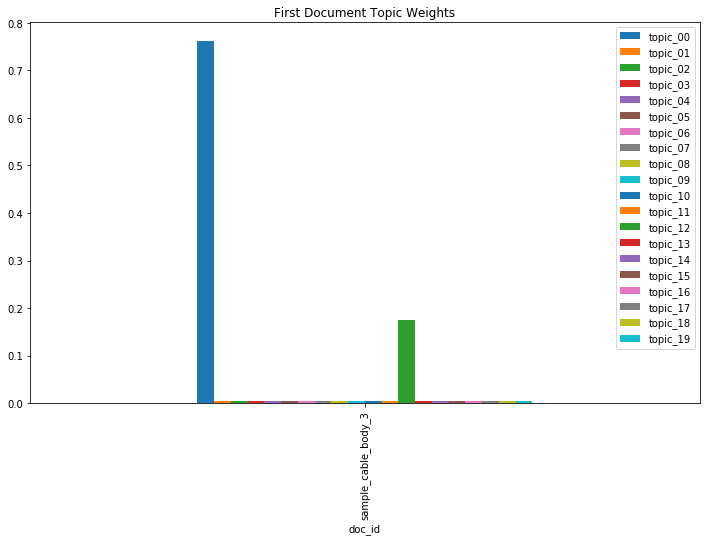

In [51]:
##
lda.pr_topic_g_doc.T.iloc[[0]].plot(kind='bar', figsize=(12,7),
                                   title = 'First Document Topic Weights')

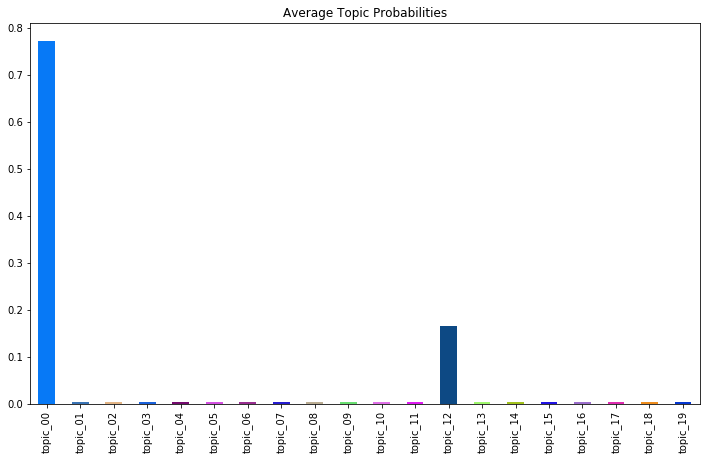

In [52]:
#or at the average topic probabilties 
import random
r = lambda: random.randint(0,255)
my_colors = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(20)]
#my_colors = 'rgbkymc'
lda.pr_topic_g_doc.mean(axis=1).plot(kind='bar', figsize=(12,7), color=my_colors,
                                     title='Average Topic Probabilities')

##You can grab a copy of this [notebook](https://github.com/columbia-applied-data-science/rosetta/tree/master/notebooks) in the [Rosetta repo](https://github.com/columbia-applied-data-science/rosetta). 

##[Rosetta](https://github.com/columbia-applied-data-science/rosetta)
    *Install, fork, submnit issues, contribute!


#Have fun!


#This notebook was created by Daniel Krasner and updated for Python 3 by Clara Suong.